# Week 3 - Predicting Default Probability

This notebook carries out the following steps
  1. Reads the original data including all the fields added by Lending Club to predict default probability
  2. Redo the prediction using only the fields available in our saved pickle file
  3. Start with predicting default using only signals such as the grade or interest assigned to a loan by Lending Club
  4. Redo the analysis only with variables available at the time of loan application
  
Things for you to do
- Variable Selection for Tree and Logistic Regression Models
- Tuning the Tree Model for Performance and Explanation
- Tuning the Logistic Regression for Performance and Explanation
- Model Comparison (Think about how you might choose one of these classifiers for downstream analysis of picking out the best loans to invest in. Will you use a batch, rank-ordered or customized assessment method to pick between these models? How much do you care about the interpretability of the chosen model in this decision?)
- Optional: Try other models for prediction while answering the same questions as above (feature selection, tuning, explainability)
- Optional: You may compare the default probabilities predicted from Step 4 above with the grades assigned by Lending Club to see if they capture the same signal as your models

Prepare your presentation. Your presentation should contain at most 6 slides. Add an extra slide at the end if you tried the BONUS.

1.  Begin by stating the objective of the presentation and what your objective is. Which questions do you seek to answer? What are the main points of the presentation?
2. Feature engineering: Describe the results you got when there is data leakage. What is the final set of variables that you use? Did you generate your own variables? If so, explain what these variables capture.
3. (4.) Provide an intuitive explanation of at least two predictive models tried. How do you think they are determining if a loan will default or not? Do these results help you better understand the problem or the data? Compare the results of the models in the context of their use in the investment problem. Which metric did you use to compare them and why? For the logistic regression, start with the ouput model data and rank the significant coeffs in decreasing order of importance
5. State your conclusions. What is the main idea you wish to convey with the presentation? Do you think the findings from this script will be useful to solve the overall problem? What are the main takeaways of the analysis you performed?

BONUS

- Can you improve your models using the results from module 2? If so, clearly state the improvements in terms of the metric you used to evaluate your models.

- Can you derive new variables from the original ones to improve your models? If so, clearly state the improvements in terms of the metric you used to evaluate your models.

- Use a more sophisticated (although less interpretable) predictive model such as tree boosting or support vector machine to obtain new results. Do these models perform better?

- Are there any exogenous variables (i.e. variables from other data sets, such as economic growth of the country) you might use to improve your models?



## Step 1 - Load the raw data again and predict default from all available fields

In [1]:
# Load general utilities
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import numpy as np
import pickle
import time
import seaborn as sns
import os

# Load sklearn utilities
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, brier_score_loss, mean_squared_error, r2_score
from sklearn.calibration import calibration_curve

# Load classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegressionCV

# Load debugger, if required
#import pixiedust
pd.options.mode.chained_assignment = None #'warn'

In [2]:
import pixiedust

Pixiedust database opened successfully


### Read downloaded file(s) again

In [3]:
## If you are re-running the script again and want to load all the models you have computed already and stored
# reload them from a saved dill file by uncommenting the next two lines and using the appropriate dill file name
# import dill
# dill.load_session('finalweek3.pkl')

In [8]:
# load the data from the file
directory = 'C:\\Users\\ly266e\\Documents\\Training\\CMU\\Master\\Fall 2023 Mini 7\\Business_Analytics\\HW\\Data\\'
all_files = os.listdir(directory)
output = {}
for i in all_files:
    print("    Reading file " + i)
    output[i] = pd.read_csv(directory + i, dtype = str, skiprows = 1)

    Reading file LoanStats3b.csv
    Reading file LoanStats3c.csv


In [10]:
data = pd.concat([output[i] for i in output.keys()], join='inner')

data = data[['id','loan_amnt','funded_amnt','funded_amnt_inv','term','int_rate',
         'installment','grade','sub_grade','emp_title','emp_length',
         'home_ownership','annual_inc','verification_status','issue_d',
         'loan_status','purpose','title','zip_code','addr_state','dti','total_pymnt',
         'delinq_2yrs','earliest_cr_line','open_acc','pub_rec','last_pymnt_d',
         'last_pymnt_amnt','application_type','revol_bal','revol_util','recoveries']]

data.dropna(subset=['annual_inc','loan_status','issue_d','last_pymnt_d','loan_amnt',
                    'int_rate','earliest_cr_line','open_acc','pub_rec','delinq_2yrs',
                    'recoveries','grade','installment','funded_amnt','dti','funded_amnt_inv',
                    'revol_bal','revol_util'],inplace=True)
data.shape

(423211, 32)

In [11]:
# Identify the type of each of these column
float_cols = ['loan_amnt', 'funded_amnt', 'installment', 'annual_inc',
            'dti', 'revol_bal', 'delinq_2yrs', 'open_acc', 'pub_rec', 'total_pymnt', 'recoveries']

cat_cols = ['term', 'grade', 'emp_length', 'home_ownership',
            'verification_status', 'loan_status', 'purpose']

perc_cols = ['int_rate', 'revol_util']

date_cols = ['issue_d', 'earliest_cr_line', 'last_pymnt_d']

for j in float_cols:
    data[j] = pd.to_numeric(data[j])
    
for j in perc_cols:
    data[j] = data[j].str.strip('%')
    data[j] = pd.to_numeric(data[j])
    data[j] = data[j]/100

for j in date_cols:
    data[j] = pd.to_datetime(data[j])

### Engineer the features and generate the training/testing set

In [12]:
default_seed = 1
np.random.seed(default_seed)

# select only terminated loans
data = data[data.loan_status.isin(['Fully Paid','Charged Off','Default'])]

# downsample
data = data.sample(n=5000)

# create labels for the dataset
data['label'] = (data.loan_status.str.contains('Charged Off') | 
                data.loan_status.str.contains('Default'))
data['cr_hist'] = (data.issue_d - data.earliest_cr_line) / np.timedelta64(1, 'M')
data.label = data.label.astype(int)

# clean and get training/testing data 
temp = pd.get_dummies(data[['term','grade','emp_length','home_ownership',
                                  'verification_status','purpose']], dummy_na=True)
subdata = data[['loan_amnt','funded_amnt','int_rate','installment',
                'annual_inc','dti','delinq_2yrs','open_acc','pub_rec', 'cr_hist','revol_bal',
                            'recoveries', 'revol_util', 'total_pymnt']]
X = subdata.to_numpy()
#X = data.as_matrix(columns=['loan_amnt','funded_amnt','int_rate','installment',
#                            'annual_inc','dti','delinq_2yrs','open_acc','pub_rec',
#                            'cr_hist','revol_bal',
#                            'recoveries',
#                            'revol_util', 'total_pymnt'])

#X = np.concatenate((X,temp.as_matrix()),axis=1)
X = np.concatenate((X,temp.to_numpy()),axis=1)

#y = data.label.as_matrix()
y = data.label.to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

min_max_scaler = preprocessing.MinMaxScaler()
X_train = min_max_scaler.fit_transform(X_train)
X_test = min_max_scaler.transform(X_test)

print(X_train.shape)
print(X_test.shape)

(3500, 61)
(1500, 61)


## Classification models

### $l_2$ penalized logistic regression

In [13]:
logisticModel = LogisticRegressionCV(cv=10,penalty='l2',max_iter=2000)
logisticModel.fit(X_train,y_train)

LogisticRegressionCV(cv=10, max_iter=2000)

In [14]:
y_pred = logisticModel.predict(X_test)
print('accuracy: ',accuracy_score(y_test,y_pred))
target_names = ['Non-Defaulted Loan','Defaulted Loan']

print(classification_report(y_test,y_pred,target_names=target_names,digits=4))
print('AUC: ',roc_auc_score(y_test,logisticModel.predict_proba(X_test)[:,1]))

accuracy:  0.9933333333333333
                    precision    recall  f1-score   support

Non-Defaulted Loan     0.9927    0.9992    0.9959      1225
    Defaulted Loan     0.9963    0.9673    0.9815       275

          accuracy                         0.9933      1500
         macro avg     0.9945    0.9832    0.9887      1500
      weighted avg     0.9934    0.9933    0.9933      1500

AUC:  0.9942441558441558


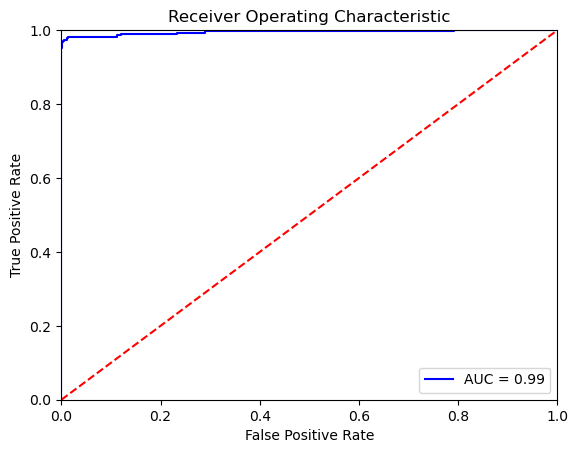

In [15]:
fpr, tpr, thresholds = roc_curve(y_test, logisticModel.predict_proba(X_test)[:,1],
                                         pos_label=1)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',
label='AUC = %0.2f'% roc_auc_score(y_test,logisticModel.predict_proba(X_test)[:,1]))
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Random forest
In addition to logistic regression, let's also take a quick look at random forest

In [16]:
random_forest = RandomForestClassifier(min_samples_leaf=100,n_estimators=50)
random_forest.fit(X_train,y_train)
y_pred = random_forest.predict(X_test)
print('accuracy: ',accuracy_score(y_test,y_pred))
target_names = ['Non-Defaulted Loan','Defaulted Loan']
print(classification_report(y_test,y_pred,target_names=target_names,digits=4))
print('AUC: ',roc_auc_score(y_test,random_forest.predict_proba(X_test)[:,1]))

accuracy:  0.8706666666666667
                    precision    recall  f1-score   support

Non-Defaulted Loan     0.8633    1.0000    0.9266      1225
    Defaulted Loan     1.0000    0.2945    0.4551       275

          accuracy                         0.8707      1500
         macro avg     0.9316    0.6473    0.6908      1500
      weighted avg     0.8883    0.8707    0.8402      1500

AUC:  0.9651562152133581


As we can see, with leaked features the AUC of the prediction models is ridiculously high

# Step 2 - Redo predictions with the columns stored in our pickle file

In [17]:
# Load general utilities
# ----------------------
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.axes as ax
import datetime
import numpy as np
import pickle
import time
import seaborn as sns

# Load sklearn utilities
# ----------------------
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, brier_score_loss, mean_squared_error, r2_score
from sklearn.calibration import calibration_curve

# Load classifiers
# ----------------
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier

# Other Packages
# --------------
from scipy.stats import kendalltau
from sklearn.neural_network import MLPRegressor
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
## from gurobipy import *
# from sklearn.externals.six import StringIO
from six import StringIO
from IPython.display import Image
from sklearn.tree import export_graphviz
!conda install -y pydotplus
import pydotplus
#from scipy.interpolate import spline

# Load debugger, if required
#import pixiedust
pd.options.mode.chained_assignment = None #'warn'

# suppress all warnings
import warnings
warnings.filterwarnings("ignore")

Retrieving notices: ...working... done
Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\ly266e\Anaconda3

  added / updated specs:
    - pydotplus


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2023.08.22 |       haa95532_0         123 KB
    cairo-1.16.0               |       he04af86_2         1.5 MB
    certifi-2023.7.22          |   py39haa95532_0         154 KB
    expat-2.5.0                |       hd77b12b_0         225 KB
    fribidi-1.0.10             |       h62dcd97_0          63 KB
    getopt-win32-0.1           |       h2bbff1b_0          19 KB
    glib-2.69.1                |       h5dc1a3c_1         1.6 MB
    graphite2-1.3.14           |       hd77b12b_1          91 KB
    graphviz-2.50.0            |       hdb8b0d4_0         903 KB
    gts-0.7.6                  |       h63ab5a1_3         181 KB
    harfbuzz


The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - defaults/win-64::anaconda-client==1.11.0=py39haa95532_0
  - defaults/win-64::anaconda==custom=py39_1
  - defaults/win-64::anaconda-navigator==2.4.0=py39haa95532_0
  - defaults/win-64::anaconda-project==0.11.1=py39haa95532_0
  - defaults/noarch::argon2-cffi==21.3.0=pyhd3eb1b0_0
  - defaults/noarch::arrow==1.2.2=pyhd3eb1b0_0
  - defaults/win-64::astroid==2.11.7=py39haa95532_0
  - defaults/noarch::babel==2.9.1=pyhd3eb1b0_0
  - defaults/win-64::bkcharts==0.2=py39haa95532_1
  - defaults/win-64::black==22.6.0=py39haa95532_0
  - defaults/win-64::bokeh==2.4.3=py39haa95532_0
  - defaults/win-64::click==8.0.4=py39haa95532_0
  - defaults/win-64::conda==23.1.0=py39haa95532_0
  - defaults/win-64::conda-build==3.22.0=py39haa95532_0
  - defaults/win-64::conda-package-handling==1.9.0=py39h8cc25b3_0
  - defaults/win-64::conda-repo-cli==1.0.20=py39haa95532_0
  - defaults/n

In [18]:
# Define a function that, given a CVGridSearch object, finds the percentage difference between the best and worst scores
def find_score_variation(cv_model):
    all_scores = cv_model.cv_results_['mean_test_score']
    return( np.abs((max(all_scores) - min(all_scores))) * 100 / max(all_scores) )

    '''
    which_min_score = np.argmin(all_scores)

    all_perc_diff = []

    try:
        all_perc_diff.append( np.abs(all_scores[which_min_score - 1] - all_scores[which_min_score])*100 / min(all_scores) )
    except:
        pass

    try:
        all_perc_diff.append( np.abs(all_scores[which_min_score + 1] - all_scores[which_min_score])*100 / min(all_scores) )
    except:
        pass

    return ( np.mean(all_perc_diff) )
    '''

# Define a function that checks, given a CVGridSearch object,
# whether the optimal parameters lie on the edge of the search
# grid
def find_opt_params_on_edge(cv_model):
    out = False

    for i in cv_model.param_grid:
        if cv_model.best_params_[i] in [ cv_model.param_grid[i][0], cv_model.param_grid[i][-1] ]:
            out = True
            break

    return out

## Define a default random seed and an output file

In [19]:
default_seed = 1
output_file = "output_sample_ravi"

In [20]:
# Create a function to print a line to our output file
def dump_to_output(key, value):
    with open(output_file, "a") as f:
        f.write(",".join([str(default_seed), key, str(value)]) + "\n")

## Load the data and engineer the features

In [21]:
# Read the data and features from the pickle
data, discrete_features, continuous_features, ret_cols = pickle.load( open( "../Week 2/PickleData/ret_data.pickle", "rb" ) )

FileNotFoundError: [Errno 2] No such file or directory: '../Week 2/PickleData/ret_data.pickle'

In [ ]:
discrete_features

In [ ]:
continuous_features

In [ ]:
data.shape

In [ ]:
# Create the outcome
data["outcome"] = data.loan_status.isin(["Charged Off", "Default"])

In [ ]:
# Create a feature for the length of a person's credit history at the time the loan is issued
data['cr_hist'] = (data.issue_d - data.earliest_cr_line) / np.timedelta64(1, 'M')
continuous_features.append('cr_hist')

In [ ]:
# Randomly assign each row to a training and test set. We do this now
# because we will be fitting a variety of models on various time periods,
# and we would like every period to use the *same* training/test split
np.random.seed(default_seed)
data['train'] = np.random.choice([True, False], size = len(data), p = [0.7, 0.3])

In [ ]:
# Create a matrix of features and outcomes, with dummies. Record the names of the dummies for later use
X_continuous = data[continuous_features].values

X_discrete = pd.get_dummies(data[discrete_features], dummy_na = True, prefix_sep = "::", drop_first = True)
discrete_features_dummies = X_discrete.columns.tolist()
X_discrete = X_discrete.values

X = np.concatenate( (X_continuous, X_discrete), axis = 1 )

y = data.outcome.values

train = data.train.values

In [ ]:
continuous_features

In [ ]:
discrete_features_dummies

In [ ]:
X.shape

## Prepare functions to fit and evaluate models

In [ ]:
def prepare_data(data_subset = np.array([True]*len(data)),
                    n_samples_train = 25000,
                    n_samples_test = 10000,
                    feature_subset = None,
                    date_range_train = (data.issue_d.min(), data.issue_d.max()),
                    date_range_test = (data.issue_d.min(), data.issue_d.max()),
                    random_state = default_seed):
    '''
    This function will prepare the data for classification or regression.
    It expects the following parameters:
      - data_subset: a numpy array with as many entries as rows in the
                     dataset. Each entry should be True if that row
                     should be used, or False if it should be ignored
      - n_samples_train: the total number of samples to be used for training.
                         Will trigger an error if this number is larger than
                         the number of rows available after all filters have
                         been applied
      - n_samples_test: as above for testing
      - feature_subect: A list containing the names of the features to be
                        used in the model. In None, all features in X are
                        used
      - date_range_train: a tuple containing two dates. All rows with loans
                          issued outside of these two dates will be ignored in
                          training
      - date_range_test: as above for testing
      - random_state: the random seed to use when selecting a subset of rows

    Note that this function assumes the data has a "Train" column, and will
    select all training rows from the rows with "True" in that column, and all
    the testing rows from those with a "False" in that column.

    This function returns a dictionary with the following entries
      - X_train: the matrix of training data
      - y_train: the array of training labels
      - train_set: a Boolean vector with as many entries as rows in the data
                  that denotes the rows that were used in the train set
      - X_test: the matrix of testing data
      - y_test: the array of testing labels
      - test_set: a Boolean vector with as many entries as rows in the data
                  that denotes the rows that were used in the test set
    '''

    np.random.seed(random_state)

    # Filter down the data to the required date range, and downsample
    # as required
    filter_train = ( train & (data.issue_d >= date_range_train[0]) &
                            (data.issue_d <= date_range_train[1]) & data_subset ).values
    filter_test = ( (train == False) & (data.issue_d >= date_range_test[0])
                            & (data.issue_d <= date_range_test[1]) & data_subset ).values

    filter_train[ np.random.choice( np.where(filter_train)[0], size = filter_train.sum()
                                   - n_samples_train, replace = False ) ] = False
    filter_test[ np.random.choice( np.where(filter_test)[0], size = filter_test.sum()
                                   - n_samples_test, replace = False ) ] = False

    # Prepare the training and test set
    X_train = X[ filter_train , :]
    X_test = X[ filter_test, :]
    if feature_subset != None:
        cols = [i for i, j in enumerate(continuous_features + discrete_features_dummies)
                                                     if j.split("::")[0] in feature_subset]
        X_train = X_train[ : , cols ]
        X_test = X_test[ : , cols ]

    y_train = y[ filter_train ]
    y_test = y[ filter_test ]

    # Scale the variables
    scaler = preprocessing.MinMaxScaler()

    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # return training and testing data
    out = {'X_train':X_train, 'y_train':y_train, 'train_set':filter_train,
           'X_test':X_test, 'y_test':y_test, 'test_set':filter_test}

    return out

In [ ]:
def fit_classification(model, data_dict,
                          cv_parameters = {},
                          model_name = None,
                          random_state = default_seed,
                          output_to_file = True,
                          print_to_screen = True):
    '''
    This function will fit a classification model to data and print various evaluation
    measures. It expects the following parameters
      - model: an sklearn model object
      - data_dict: the dictionary containing both training and testing data;
                   returned by the prepare_data function
      - cv_parameters: a dictionary of parameters that should be optimized
                       over using cross-validation. Specifically, each named
                       entry in the dictionary should correspond to a parameter,
                       and each element should be a list containing the values
                       to optimize over
      - model_name: the name of the model being fit, for printouts
      - random_state: the random seed to use
      - output_to_file: if the results will be saved to the output file
      - print_to_screen: if the results will be printed on screen

    If the model provided does not have a predict_proba function, we will
    simply print accuracy diagnostics and return.

    If the model provided does have a predict_proba function, we first
    figure out the optimal threshold that maximizes the accuracy and
    print out accuracy diagnostics. We then print an ROC curve, sensitivity/
    specificity curve, and calibration curve.

    This function returns a dictionary with the following entries
      - model: the best fitted model
      - y_pred: predictions for the test set
      - y_pred_probs: probability predictions for the test set, if the model
                      supports them
      - y_pred_score: prediction scores for the test set, if the model does not
                      output probabilities.
    '''

    np.random.seed(random_state)

    # --------------------------
    #   Step 1 - Load the data
    # --------------------------
    
    X_train = data_dict['X_train']
    y_train = data_dict['y_train']

    X_test = data_dict['X_test']
    y_test = data_dict['y_test']

    filter_train = data_dict['train_set']

    # --------------------------
    #   Step 2 - Fit the model
    # --------------------------

    cv_model = GridSearchCV(model, cv_parameters)

    start_time = time.time()
    cv_model.fit(X_train, y_train)
    end_time = time.time()

    best_model = cv_model.best_estimator_

    if print_to_screen:

        if model_name != None:
            print("=========================================================")
            print("  Model: " + model_name)
            print("=========================================================")

        print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
        print("Optimal parameters:")
        print(cv_model.best_params_)
        print("")

    # -------------------------------
    #   Step 3 - Evaluate the model
    # -------------------------------

    # If possible, make probability predictions
    try:
        y_pred_probs = best_model.predict_proba(X_test)[:,1]
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)

        probs_predicted = True
    except:
        probs_predicted = False

    # Make predictions; if we were able to find probabilities, use
    # the threshold that maximizes the accuracy in the training set.
    # If not, just use the learner's predict function
    if probs_predicted:
        y_train_pred_probs = best_model.predict_proba(X_train)[:,1]
        fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_pred_probs)

        true_pos_train = tpr_train*(y_train.sum())
        true_neg_train = (1 - fpr_train) *(1-y_train).sum()

        best_threshold_index = np.argmax(true_pos_train + true_neg_train)
        best_threshold = 1 if best_threshold_index == 0 else thresholds_train[ best_threshold_index ]

        if print_to_screen:
            print("Accuracy-maximizing threshold was: " + str(best_threshold))

        y_pred = (y_pred_probs > best_threshold)
    else:
        y_pred = best_model.predict(X_test)

    if print_to_screen:
        print("Accuracy: ", accuracy_score(y_test, y_pred))
        print(classification_report(y_test, y_pred, target_names =['No default', 'Default'], digits = 4))

    if print_to_screen:
        if probs_predicted:
            plt.figure(figsize = (13, 4.5))
            plt.subplot(2, 2, 1)

            plt.title("ROC Curve (AUC = %0.2f)"% roc_auc_score(y_test, y_pred_probs))
            plt.plot(fpr, tpr, 'b')
            plt.plot([0,1],[0,1],'r--')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.ylabel('True Positive Rate')
            plt.xlabel('False Positive Rate')

            plt.subplot(2, 2, 3)

            plt.plot(thresholds, tpr, 'b', label = 'Sensitivity')
            plt.plot(thresholds, 1 -fpr, 'r', label = 'Specificity')
            plt.legend(loc = 'lower right')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.xlabel('Threshold')

            plt.subplot(2, 2, 2)

            fp_0, mpv_0 = calibration_curve(y_test, y_pred_probs, n_bins = 10)
            plt.plot([0,1], [0,1], 'k:', label='Perfectly calibrated')
            plt.plot(mpv_0, fp_0, 's-')
            plt.ylabel('Fraction of Positives')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.legend(loc ='upper left')

            plt.subplot(2, 2, 4)
            plt.hist(y_pred_probs, range=(0, 1), bins=10, histtype="step", lw=2)
            plt.xlim([0,1]); plt.ylim([0,20000])
            plt.xlabel('Mean Predicted Probability')
            plt.ylabel('Count')

            #plt.tight_layout()
            plt.show()

    # Additional Score Check
    if probs_predicted:
        y_train_score = y_train_pred_probs
    else:
        y_train_score = best_model.decision_function(X_train)

    tau, p_value = kendalltau(y_train_score, data.grade[filter_train])
    if print_to_screen:
        print("")
        print("Similarity to LC grade ranking: ", tau)

    if probs_predicted:
        brier_score = brier_score_loss(y_test, y_pred_probs)
        if print_to_screen:
            print("Brier score:", brier_score)

    # Return the model predictions, and the
    # test set
    # -------------------------------------
    out = {'model':best_model, 'y_pred_labels':y_pred}

    if probs_predicted:
        out.update({'y_pred_probs':y_pred_probs})
    else:
        y_pred_score = best_model.decision_function(X_test)
        out.update({'y_pred_score':y_pred_score})

    # Output results to file
    # ----------------------
    if probs_predicted and output_to_file:
        # Check whether any of the CV parameters are on the edge of
        # the search space
        opt_params_on_edge = find_opt_params_on_edge(cv_model)
        dump_to_output(model_name + "::search_on_edge", opt_params_on_edge)
        if print_to_screen:
            print("Were parameters on edge? : " + str(opt_params_on_edge))

        # Find out how different the scores are for the different values
        # tested for by cross-validation. If they're not too different, then
        # even if the parameters are off the edge of the search grid, we should
        # be ok
        score_variation = find_score_variation(cv_model)
        dump_to_output(model_name + "::score_variation", score_variation)
        if print_to_screen:
            print("Score variations around CV search grid : " + str(score_variation))

        # Print out all the scores
        dump_to_output(model_name + "::all_cv_scores", str(cv_model.cv_results_['mean_test_score']))
        if print_to_screen:
            print( str(cv_model.cv_results_['mean_test_score']) )

        # Dump the AUC to file
        dump_to_output(model_name + "::roc_auc", roc_auc_score(y_test, y_pred_probs) )

    return out

## Step 3 - Baseline models
See how well we do using grade or interest rate only

### Grade

In [ ]:
data_dict = prepare_data(feature_subset=['grade'])
grade_only_logistic = LogisticRegression(penalty = 'l2', C=np.inf, solver='lbfgs')

grade_only_logistic = fit_classification(grade_only_logistic,data_dict,
                                         model_name = 'Grade only logistic l2')

In [ ]:
data_dict = prepare_data(feature_subset=['int_rate'])
interest_only_logistic = LogisticRegression(penalty = 'l2', C=np.inf, solver='lbfgs')

interest_only_logistic = fit_classification(interest_only_logistic, data_dict,
                                   model_name = 'Interest rate only logistics l2')

## Step 4- Test models without grade or interest rate

In [ ]:
final_features = [i for i in discrete_features + continuous_features if i not in ["grade", "int_rate", "installment"]]
data_dict = prepare_data(feature_subset = final_features)

all_features = pd.Series(continuous_features + discrete_features_dummies)
idx = [i for i, j in enumerate(continuous_features + discrete_features_dummies)
                                                     if j.split("::")[0] in final_features]
selected_features = all_features[idx]
selected_features.reset_index(drop=True,inplace=True)

In [ ]:
final_features

### Ridge Classifier

In [ ]:
ridge_classifier = RidgeClassifier()
cv_parameters = {"alpha":np.logspace(-4, 4, num = 10)}

ridge_classifier = fit_classification(ridge_classifier, data_dict,
                             cv_parameters = cv_parameters, model_name = "Ridge Classifier")

### Naive Bayes

In [ ]:
gnb = GaussianNB()
gnb = fit_classification(gnb, data_dict,
                model_name = "Gaussian Naive Bayes")


### $l_1$ penalized logistic regression
(Takes a couple of minutes)

In [ ]:
#Use version loaded from pickle
l1_logistic = LogisticRegression(penalty = 'l1',solver='liblinear')
cv_parameters = {"C":np.logspace(0, 6, num = 10)}

l1_logistic = fit_classification(l1_logistic, data_dict,
                       cv_parameters = cv_parameters, model_name = "l1 Penalized Logistic Regression")

In [ ]:
## plot top 3 features with the most positive (and negative) weights
top_and_bottom_idx = list(np.argsort(l1_logistic['model'].coef_)[0,:3]) + list(np.argsort(l1_logistic['model'].coef_)[0,-3:])
bplot = pd.Series(l1_logistic['model'].coef_[0,top_and_bottom_idx])
xticks = selected_features[top_and_bottom_idx]
p1 = bplot.plot(kind='bar',rot=-30,ylim=(-2,3))
p1.set_xticklabels(xticks)
plt.show()

### $l_2$ penalized logistic regression

In [ ]:
#Use version loaded from pickle
l2_logistic = LogisticRegression(penalty = 'l2')
cv_parameters = {"C":np.logspace(-4, 4, num = 10)}

l2_logistic = fit_classification(l2_logistic, data_dict,
                       cv_parameters = cv_parameters, model_name = "l2 Penalized Logistic Regression")

In [ ]:
## plot top 3 features with the most positive (and negative) weights
top_and_bottom_idx = list(np.argsort(l2_logistic['model'].coef_)[0,:3]) + list(np.argsort(l2_logistic['model'].coef_)[0,-3:])
bplot = pd.Series(l2_logistic['model'].coef_[0,top_and_bottom_idx])
xticks = selected_features[top_and_bottom_idx]
p1 = bplot.plot(kind='bar',rot=-30,ylim=(-2,3))
p1.set_xticklabels(xticks)
plt.show()

### Decision tree

In [ ]:
#Use version loaded from pickle
decision_tree = DecisionTreeClassifier()
cv_parameters = {'min_samples_leaf':[500,600,700,800,900,1000, 1100, 1200, 1300]}

decision_tree = fit_classification(decision_tree, data_dict,
                         cv_parameters = cv_parameters, model_name = "Decision tree")

In [ ]:
# Visualize the decision tree
# Zooming-in is allowed by double click
!conda install -c conda-forge pygraphviz -y
!conda install python-graphviz pydot -y
import graphviz

dot_data = StringIO()
export_graphviz(decision_tree['model'], out_file=dot_data,
                feature_names=selected_features,filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

### Random forest
Takes nearly 10 minutes given the large data set!

In [ ]:
#Use version loaded from pickle
random_forest = RandomForestClassifier()
cv_parameters = {'min_samples_leaf':[1, 2, 3, 5, 8, 13, 17, 20, 40], 'n_estimators': [35, 60, 80, 100, 150] }

random_forest_model = fit_classification(random_forest, data_dict,
                                   cv_parameters=cv_parameters, model_name="Random forest")

In [ ]:
## Plot top 6 most significant features
top_idx = list(np.argsort(random_forest_model['model'].feature_importances_)[-6:])
bplot = pd.Series(random_forest_model['model'].feature_importances_[top_idx])
xticks = selected_features[top_idx]
p2 = bplot.plot(kind='bar',rot=-30,ylim=(0,0.2))
p2.set_xticklabels(xticks)
plt.show()

In [ ]:
## A decision tree trained on the scores of random forest
trepin_tree = DecisionTreeClassifier(min_samples_leaf = 100, max_depth = 4)
trepin_tree.fit(random_forest_model['y_pred_probs'].reshape(-1,1),data_dict['y_test'])
dot_data = StringIO()
export_graphviz(trepin_tree, out_file=dot_data,
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

### Bagged trees
Takes a very long time for the whole LC data set!!

In [ ]:
# Use saved version
bagged_trees = RandomForestClassifier(max_features = 1.0)
cv_parameters = {'min_samples_leaf':[5, 10, 25, 50, 75, 100, 200], 'n_estimators': [60, 100, 150, 200, 300] }

bagged_trees_model = fit_classification(bagged_trees, data_dict,
                                  cv_parameters=cv_parameters, model_name="Bagged trees")

In [ ]:
## Plot top 6 most significant features
top_idx = list(np.argsort(bagged_trees_model['model'].feature_importances_)[-6:])
bplot = pd.Series(bagged_trees_model['model'].feature_importances_[top_idx])
xticks = selected_features[top_idx]
p2 = bplot.plot(kind='bar',rot=-30,ylim=(0,0.2))
p2.set_xticklabels(xticks)
plt.show()

## Save a "dill" of all your models for later use
If you ran complicated models that has taken considerable time, you can save these models in a dump of the whole session (not just the data) using a version of pickling called "dill" as follows.

In [ ]:
!conda install dill -y
import dill
dill.dump_session('finalweek3.pkl')

#The above command dumps a file in the current directory which you can load later as follows
# import dill
# dill.load_session('week3.pkl')